In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss
%matplotlib inline

In [82]:
#pip install rpy2

# Data Quality Check

## Demographics

In [6]:
demographics = pd.read_csv('data_exp_6138-v39_questionnaire-zk38.csv', sep = ",")
#demographics.head(15)
# we asked them 7 questions in total

In [7]:
demographics = demographics[demographics['Question Key'] != 'BEGIN QUESTIONNAIRE']
demographics = demographics[demographics['Question Key'] != 'END QUESTIONNAIRE']
demographics['id'] = demographics['Participant Private ID']
demographics['question'] = demographics['Question Key']
demographics['response'] = demographics['Response']
demographics = demographics[['id', 'question', 'response']]

In [8]:
d = pd.pivot_table(demographics, index = 'id', columns = 'question', values = 'response', aggfunc='first')
d = d.reset_index()
d.columns= ['id','age', 'confirmation_1', 'confirmation_2', 'gender', 'gender_numeric','handedness', 'handedness_numeric', 'degree', 'degree_numeric']


In [9]:
d['age'].astype(float).mean()

37.76

In [10]:
d.to_csv('demographics_100.csv', sep = ',', encoding='utf-8')

## Sound Check

In [11]:
# do a quick check for sound
sound = pd.read_csv('data_exp_6138-v39_task-jgum.csv', sep = ",")
sound = sound.replace('null', np.nan)
sound = sound.replace('nan', np.nan)

In [12]:
sound = sound[np.isfinite(sound['button pressed'])]

In [13]:
correct = [1, 0, 0]* 100

In [14]:
s = (sound['button pressed'] == correct).reset_index(name = 'check')
sound = sound.reset_index()
sound = pd.merge(s[['index', 'check']], sound, on = 'index')
sound_final= sound[['Participant Private ID','button pressed','check']]

In [15]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)
#sound_final.head(300)

## rod fixing count

In [16]:
#import csv
#2jau and 5e3j are low-high and high-low
df1 = pd.read_csv('data_exp_6138-v39_task-2jau.csv', sep = ",")
df2 = pd.read_csv('data_exp_6138-v39_task-5e3j.csv', sep = ",")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#replace all null and nan to the np.nan
df1 = df1.replace('null', np.nan)
df1 = df1.replace('nan', np.nan)
df2 = df2.replace('null', np.nan)
df2 = df2.replace('nan', np.nan)

#turn object into floats and round them and rename them
df1['end_time'] = round(df1['end_time'].astype(float))
df1['start_time'] = round(df1['start_time'].astype(float))
df1['builtin_rt'] = df1['builtin rt'].astype(float) #dont round up builtin reaction time
df1['quality_check'] = df1['rod fixing checked'].astype(float)
df1['id'] = df1['Participant Private ID']
df1['function_id'] = df1['function id']
df1['round_instance'] = df1['round instance']
df1['trial_index'] = df1['index']
df1['key_pressed'] = df1['key pressed']

df2['end_time'] = round(df2['end_time'].astype(float))
df2['start_time'] = round(df2['start_time'].astype(float))
#df2['builtin_rt'] = df2['builtin rt'].astype(float) #dont round up builtin reaction time
df2['quality_check'] = df2['rod fixing checked'].astype(float)
df2['id'] = df2['Participant Private ID']
df2['round_instance'] = df2['round_instance']
df2['function_id'] = df2['function id']
df2['trial_index'] = df2['index']
df2['key_pressed'] = df2['key pressed']

In [18]:
#select columns from df1 and df2
data1 = df1[['trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed']]
data2 = df2[['trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed']]

In [19]:
data = pd.concat([data1, data2])
data.index.nunique()
index_manual = list(range(0, len(data)))
data['index'] = index_manual
data = data.set_index('index')
data = data[data.function_id != 'caller']
data = data[pd.notnull(data['function_id'])]



In [20]:
data_useful = data[(data.function_id == "rod_fixing")|(data.function_id == "fishing_l")|(data.function_id == "fishing_h")]
data_useful = data_useful.sort_values(by = ['id', 'start_time'])


In [21]:
data_useful['trial_label'] = data_useful[['trial_index', 'round_instance']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [22]:
d = data_useful.groupby(['id', 'trial_label'])['start_time'].diff().shift(-1).reset_index(name = 'latency')
d = d.set_index('index')

In [23]:
data_useful['latency'] = d['latency']
data_useful= data_useful.sort_index().sort_values(['id', 'start_time'])
data_useful.head(400)

,trial_index,id,price_displayed,key pressed,environment,order,round_instance,task,function_id,quality_check,builtin_rt,end_time,start_time,Participant Public ID,key_pressed,trial_label,latency
index,,,,,,,,,,,,,,,,,
177472,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,1722.055,1554474830320.000,1554474828597.000,BLIND,40.000,1.0 11.0,1828.000
177473,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,4.975,1554474830430.000,1554474830425.000,BLIND,40.000,1.0 11.0,109.000
177474,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,29.965,1554474830564.000,1554474830534.000,BLIND,40.000,1.0 11.0,134.000
177475,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,35.540,1554474830704.000,1554474830668.000,BLIND,40.000,1.0 11.0,138.000
177476,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,33.455,1554474830840.000,1554474830806.000,BLIND,40.000,1.0 11.0,137.000
177477,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,17.950,1554474830961.000,1554474830943.000,BLIND,40.000,1.0 11.0,124.000
177478,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,16.540,1554474831084.000,1554474831067.000,BLIND,40.000,1.0 11.0,119.000
177479,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,32.100,1554474831218.000,1554474831186.000,BLIND,40.000,1.0 11.0,135.000
177480,1.000,668220.000,1.800,40.000,low,low-high,11.000,fishing,fishing_l,nan,21.200,1554474831343.000,1554474831321.000,BLIND,40.000,1.0 11.0,132.000


In [24]:
data_rod = data_useful[(data_useful.function_id == "rod_fixing")]

In [25]:
by_trial = data_rod.groupby(['id', 'environment', 'trial_label']).count().reset_index()
#by_trial

In [26]:
by_trial_problem = by_trial[(by_trial['trial_index'] > 8) | (by_trial['trial_index'] < 5)]

### Ritiwk's codes

In [27]:
da = data_useful

In [28]:
for r_instance in da['round_instance'].unique():
    da.loc[da['round_instance'] == r_instance,'latency'] = da[da['round_instance']==r_instance].groupby('id')['start_time'].diff().shift(-1)
 

In [29]:
#da['latency'].head(400)

how are you calcualting the last latency? 

# Analysis

### Discard the first spike

In [30]:
def mask_first(x):
    """
    get rid of the first spike by creating a mask of 0, 1, 1, 1, ...
    """
    result = np.ones_like(x)
    result[0] = 0
    return result

make a copy of the original data file

In [31]:
data_original = data_useful

In [32]:
mask = data_useful.groupby(['id', 'trial_label'])['trial_label'].transform(mask_first).astype(bool)
data_useful = data_useful.loc[mask]
# now we got rid of the first spike of fishing and rod fixing

In [33]:
#data_useful.head(100)

## Fishing Data

In [34]:
data_fish = data_useful[(data_useful.function_id == "fishing_l")|(data_useful.function_id == "fishing_h")]

In [35]:
data_fish['latency'].describe()

count   315521.000
mean       189.196
std       1045.919
min         79.000
25%        149.000
50%        172.000
75%        197.000
max     344778.000
Name: latency, dtype: float64

### Outliers

In [55]:
data_fish_prunned = data_fish[data_fish['id'] != 668262.0]
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 675528.0]
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 675577.0]
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 680119.0]
len(data_fish_prunned['id'].unique())

96

### Price-Latency by environment graph

In [37]:
graph = data_fish_prunned.groupby(["price_displayed", "function_id"])['latency'].mean().reset_index()
graph.columns = ['price_displayed', 'function_id', 'average_latency']

In [38]:
price = [0.1, 0.3, 0.7, 1.2, 1.8, 2.5]
latency_l = graph.average_latency[(graph.function_id == 'fishing_l')]
latency_h = graph.average_latency[(graph.function_id == 'fishing_h')]

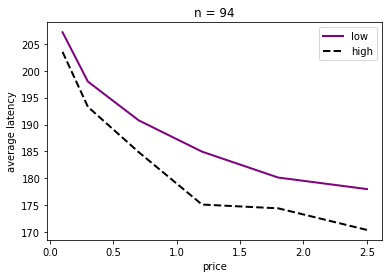

In [39]:
plt.plot( price, latency_l, marker='', color='purple', linewidth=2, label = "low")
plt.plot( price, latency_h, marker='', color='black', linewidth=2, linestyle='dashed', label="high")
plt.title("n = 94")
plt.xlabel("price")
plt.ylabel("average latency")
plt.legend()

### Linear regression with predictor price and environment

In [56]:
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='low', 0, data_fish_prunned['environment'])
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='high', 1, data_fish_prunned['environment'])
data_fish_prunned['log_latency'] = np.log(data_fish_prunned['latency'])


In [42]:
data_610 = data_fish_prunned[data_fish_prunned['id'] == 675610.0]
f_model_610 = ols(formula = 'latency ~ environment_binary + price_displayed', 
              data=data_610)
r_610 = f_model_610.fit()
#r_610.summary()

In [43]:
#pd.set_option('display.float_format', lambda x: '%.2E' % x)

In [57]:
len(data_fish_prunned)

303937

In [58]:
data_fish_prunned = data_fish_prunned.dropna(subset=['latency'])

In [59]:
len(data_fish_prunned)

300819

In [62]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed', groups = data_fish_prunned['id'], data=data_fish_prunned)
r = f_model.fit()
#print (r.summary())
#dir(r)
r.params

Intercept                    5.244
environment_binary[T.low]    0.029
price_displayed             -0.054
Group Var                    0.373
dtype: float64

In [63]:
r.pvalues

Intercept                   0.000
environment_binary[T.low]   0.000
price_displayed             0.000
Group Var                   0.000
dtype: float64

In [67]:
r.random_effects

{668220.0: Group   -0.077
 dtype: float64, 668225.0: Group   -0.062
 dtype: float64, 668237.0: Group   0.011
 dtype: float64, 668239.0: Group   -0.142
 dtype: float64, 668240.0: Group   0.001
 dtype: float64, 668244.0: Group   -0.079
 dtype: float64, 668245.0: Group   -0.010
 dtype: float64, 668246.0: Group   -0.021
 dtype: float64, 668249.0: Group   -0.040
 dtype: float64, 668251.0: Group   0.383
 dtype: float64, 668253.0: Group   -0.120
 dtype: float64, 668254.0: Group   0.052
 dtype: float64, 668263.0: Group   0.007
 dtype: float64, 668267.0: Group   -0.067
 dtype: float64, 668270.0: Group   -0.032
 dtype: float64, 668274.0: Group   -0.007
 dtype: float64, 668370.0: Group   -0.121
 dtype: float64, 672044.0: Group   0.006
 dtype: float64, 672045.0: Group   -0.149
 dtype: float64, 672046.0: Group   0.137
 dtype: float64, 672581.0: Group   -0.039
 dtype: float64, 672582.0: Group   -0.023
 dtype: float64, 672585.0: Group   0.026
 dtype: float64, 672586.0: Group   0.072
 dtype: float64, 

In [64]:
print (r.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     log_latency
No. Observations:      300819      Method:                 REML       
No. Groups:            96          Scale:                  0.0590     
Min. group size:       1114        Likelihood:             -1622.0361 
Max. group size:       4487        Converged:              Yes        
Mean group size:       3133.5                                         
----------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  5.244    0.015  345.577 0.000  5.214  5.274
environment_binary[T.low]  0.029    0.001   32.403 0.000  0.027  0.031
price_displayed           -0.054    0.001 -103.710 0.000 -0.056 -0.053
Group Var                  0.022    0.013                             



In [66]:
dir(r)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_expand_re_names',
 '_get_robustcov_results',
 'aic',
 'bic',
 'bootstrap',
 'bse',
 'bse_fe',
 'bse_re',
 'bsejac',
 'bsejhj',
 'conf_int',
 'converged',
 'cov_params',
 'cov_pen',
 'cov_re',
 'cov_re_unscaled',
 'covjac',
 'covjhj',
 'df_modelwc',
 'df_resid',
 'f_test',
 'fe_params',
 'fittedvalues',
 'freepat',
 'get_nlfun',
 'hessv',
 'hist',
 'initialize',
 'k_constant',
 'k_fe',
 'k_re',
 'k_re2',
 'k_vc',
 'llf',
 'load',
 'method',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'params_object',
 'predict',
 'profile_re',
 'pvalues',
 'random_effects',
 'random_effects_cov',
 '

In [65]:
low_latency = data_fish_prunned[data_fish_prunned.environment == 'low'].latency
high_latency = data_fish_prunned[data_fish_prunned.environment == 'high'].latency
ss.mannwhitneyu(low_latency, high_latency)

MannwhitneyuResult(statistic=10636138453.0, pvalue=4.139835208766626e-174)

### Price-Latency Plot by subject and environment

In [37]:
fish_subject = data_fish_prunned.groupby(["id","price_displayed", "environment"])['latency'].mean().reset_index()
fish_subject.columns = ['id','price_displayed', 'environment', 'average_latency']

In [ ]:
sns.set(style="ticks")
by_subject = sns.relplot(x="price_displayed", y="average_latency", hue="environment", 
            col="id", col_wrap=4,legend = 'full',
            height=5, aspect=.75, linewidth=2.5,
            kind="line",data=fish_subject)
by_subject.set(xticks= fish_subject["price_displayed"])
plt.ylim([100,300])

In [ ]:
by_subject.savefig("output100_300.png")

In [ ]:
len(data_fish.id.unique())

In [ ]:
data_fish.to_csv('fish_100.csv', sep = ',', encoding='utf-8')

## Rod Fixing Data

In [66]:
data_rod = data_original[(data_original.function_id == "rod_fixing")]

### Check if everyone tap at least once within the 13000 msecs

In [77]:
data_rod[data_rod.quality_check == 0]

,trial_index,id,price_displayed,key pressed,environment,order,round_instance,task,function_id,quality_check,builtin_rt,end_time,start_time,Participant Public ID,key_pressed,trial_label,latency
index,,,,,,,,,,,,,,,,,
56203,3.000,672596.000,0.700,39.000,high,high-low,11.000,rod_fixing,rod_fixing,0.000,17825.500,1554832873330.000,1554832855504.000,BLIND,39.000,3.0 11.0,17829.000
56416,7.000,672596.000,0.100,39.000,high,high-low,11.000,rod_fixing,rod_fixing,0.000,115515.745,1554833032422.000,1554832916905.000,BLIND,39.000,7.0 11.0,nan
340746,8.000,675669.000,1.800,39.000,low,low-high,21.000,rod_fixing,rod_fixing,0.000,20676.015,1555086572813.000,1555086552136.000,BLIND,39.000,8.0 21.0,nan
342079,4.000,675669.000,1.800,39.000,high,high-low,22.000,rod_fixing,rod_fixing,0.000,28883.955,1555086893052.000,1555086864167.000,BLIND,39.000,4.0 22.0,nan


### Check if anyone taps more than 8 times

In [67]:
by_trial_hier = data_rod.groupby(['id', 'environment', 'trial_label']).count().reset_index()
by_trial_hier['index'] = by_trial_hier[['id', 'trial_label']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
by_trial_hier = by_trial_hier.set_index('index')

In [68]:
bytrial_latency = data_rod.groupby(['id', 'environment', 'trial_label'])['latency'].sum().reset_index(name = 'sum_latency')
bytrial_latency['index'] = bytrial_latency[['id', 'trial_label']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
bytrial_latency = bytrial_latency.set_index('index')
by_trial_rod = pd.merge(by_trial_hier, bytrial_latency, left_index=True, right_index=True)


In [69]:
by_trial_rod = by_trial_rod[['id_x', 'environment_x', 'trial_label_x', 'trial_index', 'sum_latency', 'key_pressed']]
by_trial_rod.columns = ['id','environment','trial_label', 'trial_index','sum_latency', 'key_pressed']


In [84]:
by_trial_rod_problem_1 = by_trial_rod[(by_trial_rod['key_pressed'] > 8)]
by_trial_rod_problem_1.id.unique()

array([668270., 672593., 675577., 675654., 680115., 680171.])

now go back to using data_useful (no first spike)

In [85]:
data_rod = data_useful[(data_useful.function_id == "rod_fixing")]

In [87]:
data_rod.to_csv('rod_100_no_first_spike.csv', sep = ',', encoding='utf-8')

# Questionnaires

In [88]:
def extract_choice(ser):
    choice = []
    for s in ser:
        c = 0
        while c < len(s):
            r = json.loads(s[c])
            for key in r.keys():
                choice.append(r[key])
            c = c + 1
    return choice

## AMI

In [89]:
# import AMI
AMI = pd.read_csv('data_exp_6138-v39_task-j8g3.csv', sep = ",")
#AMI

In [90]:
AMI_group = AMI.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
# response = AMI_group['choice made'][0]
choice = extract_choice(AMI_group['choice made'])
AMI_group = AMI_group.loc[AMI_group.index.repeat(19)] #repeat no of questions times

In [91]:
AMI_group['choice'] = choice
AMI_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]*100

In [92]:
AMI_group.choice[AMI_group.choice == "Completely UNTRUE"] = 4
AMI_group.choice[AMI_group.choice == "Mostly untrue"] = 3
AMI_group.choice[AMI_group.choice == "Neither true nor untrue"] = 2
AMI_group.choice[AMI_group.choice == "Quite true"] = 1
AMI_group.choice[AMI_group.choice == "Completely TRUE"] = 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [93]:
# by taking the mean rating of the items within the subscale.
# bAMI = questions [5 9 10 11 12 16]
# sAMI = questions [2 3 4  8  15 18]
# eAMI = questions [1 6 7  14 17 19]
# trick_question = 13
# tAMI = sum
bAMI = AMI_group[(AMI_group.question_number == 5)|(AMI_group.question_number == 9)|(AMI_group.question_number == 10)|(AMI_group.question_number == 11)|(AMI_group.question_number == 12)|(AMI_group.question_number == 16)]
sAMI = AMI_group[(AMI_group.question_number == 2)|(AMI_group.question_number == 3)|(AMI_group.question_number == 4)|(AMI_group.question_number == 8)|(AMI_group.question_number == 15)|(AMI_group.question_number == 18)]
eAMI = AMI_group[(AMI_group.question_number == 1)|(AMI_group.question_number == 6)|(AMI_group.question_number == 7)|(AMI_group.question_number == 14)|(AMI_group.question_number == 17)|(AMI_group.question_number == 19)]
trick_AMI = AMI_group[(AMI_group.question_number == 13)]
bAMI = bAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
bAMI.columns = ['id', 'bAMI']
bAMI['score'] = bAMI['bAMI']/6
sAMI = sAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
sAMI.columns = ['id', 'sAMI']
sAMI['score'] = sAMI['sAMI']/6
eAMI = eAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
eAMI.columns = ['id', 'eAMI']
eAMI['score'] = eAMI['eAMI']/6
AMI_final = {'id': bAMI['id'], 'bAMI': bAMI['score'], 'sAMI': sAMI['score'], 'eAMI': eAMI['score']}
AMI_final = pd.DataFrame(data=AMI_final)
AMI_final['tAMI'] = (bAMI['score'] + sAMI['score'] + eAMI['score'])/3

In [94]:
AMI_final.to_csv('AMI_100.csv', sep = ',', encoding='utf-8')

## HAD

In [104]:
# import HAD
HAD = pd.read_csv('data_exp_6138-v39_task-w8es.csv', sep = ",")
HAD.drop(HAD.tail(1).index,inplace=True)
HAD = HAD[HAD['Participant Private ID'] != 668245] # twice

In [105]:
HAD_group = HAD.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(HAD_group['choice made'])
HAD_group = HAD_group.loc[HAD_group.index.repeat(15)]


In [106]:
len(HAD_group["Participant Private ID"].unique())

99

In [107]:
HAD_group['choice'] = choice
HAD_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*99

In [108]:
# question 12 is the trick question
HAD_group['scale'] = [{"Most of the time" : 3, "A lot of the time": 2, "From time to time, occasionally" : 1, "Not at all":0},
                      {"Nearly all the time": 3, "Very often": 2, "Sometimes": 1, "Not at all":0},
                      {"Definitely as much":0, "Not quite so much":1, "Only a little":2, "Hardly at all":3},
                      {"Not at all":0, "Occasionally":1, "Quite Often":2, "Very Often":3},
                      {"Very definitely and quite badly":3, "Yes, but not too badly":2, "A little, but it doesn't worry me":1, "Not at all":0},
                      {"Definitely":3, "I don't take as much care as I should":2,"I may not take quite as much care":1, "I take just as much care as ever":0},
                      {"As much as I always could":0, "Not quite so much now":1, "Definitely not so much now":2, "Not at all":3},
                      {"Very much indeed":3, "Quite a lot":2,"Not very much":1, "Not at all":0},
                      {"A great deal of the time":3, "A lot of the time":2, "From time to time, but not too often":1,"Only occasionally":0},
                      {"As much as I ever did":0, "Rather less than I used to":1, "Definitely less than I used to":2, "Hardly at all":3},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Very often indeed":3, "Quite often":2,"Not very often":1, "Not at all":0},
                      {"Definitely":0, "Usually":1, "Not Often":2,"Not at all":3},
                      {"Often":0, "Sometimes":1,"Not often":2, "Very seldom":3}]*99

In [109]:
# 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,    13, 14, 15
# A, D, D, A, A, D, D, A, A, D,   D,  trick, A,  A, D

# anxiety =  [1, 4, 5, 8, 9, 13, 14]
# depression = [2, 3, 6, 7, 10, 11, 15]

value = []
for index, row in HAD_group.iterrows():
    d = row["scale"]
    k = row['choice']
    value.append(d[k])
HAD_group['value'] = value

depression = HAD_group[(HAD_group.question_number == 2)|(HAD_group.question_number == 3)|(HAD_group.question_number == 6)|(HAD_group.question_number == 7)|(HAD_group.question_number == 10)|(HAD_group.question_number == 11)|(HAD_group.question_number == 15)]
anxiety = HAD_group[(HAD_group.question_number == 1)|(HAD_group.question_number == 4)|(HAD_group.question_number == 5)|(HAD_group.question_number == 8)|(HAD_group.question_number == 9)|(HAD_group.question_number == 13)|(HAD_group.question_number == 14)]
trick = HAD_group[(HAD_group.question_number == 12)]

In [110]:
depression = depression.groupby(['Participant Private ID'])['value'].sum().reset_index()
depression.columns = ['id', 'depression']
anxiety = anxiety.groupby(['Participant Private ID'])['value'].sum().reset_index()
anxiety.columns = ['id', 'anxiety']
#HAD_group.head(5)

In [111]:
HAD_final = {'id': anxiety['id'], 'anxiety': anxiety['anxiety'], 'depression': depression['depression']}
HAD_final = pd.DataFrame(data=HAD_final)
HAD_final['tHAD'] = anxiety['anxiety'] + depression['depression']

HAD_final.to_csv('HAD_99.csv', sep = ',', encoding='utf-8')

## Baratt

In [145]:
# import Baratt
barrat = pd.read_csv('data_exp_6138-v39_task-df75.csv', sep = ",")
barrat.drop(barrat.tail(1).index,inplace=True)

In [146]:
barrat_group = barrat.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(barrat_group['choice made'])
barrat_group = barrat_group.loc[barrat_group.index.repeat(31)]

In [147]:
barrat_group['choice'] = choice
barrat_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22, 23, 24, 25, 26, 27, 28, 29, 30, 31]*100

In [148]:
reverse_barrat = barrat_group[barrat_group['question_number'].isin([9, 21,31, 1, 7, 8, 13, 14, 10, 16, 30])]
reverse_barrat.choice[reverse_barrat.choice == "Rarely/Never"] = 4
reverse_barrat.choice[reverse_barrat.choice == "Occasionally"] = 3
reverse_barrat.choice[reverse_barrat.choice == "Often"] = 2
reverse_barrat.choice[reverse_barrat.choice == "Almost always/Always"] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [149]:
# trick question
trick_barrat = barrat_group[barrat_group['question_number']==12]

In [150]:
barrat_group = barrat_group[barrat_group['question_number'].isin([5,11,29, 6, 25, 27, 2, 3, 4, 18, 20, 23, 26, 17, 22, 24,15, 19, 29])]
barrat_group.choice[barrat_group.choice == "Rarely/Never"] = 1
barrat_group.choice[barrat_group.choice == "Occasionally"] = 2
barrat_group.choice[barrat_group.choice == "Often"] = 3
barrat_group.choice[barrat_group.choice == "Almost always/Always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

### Check if standard barrat and reverse barrat are negatively correlated

In [152]:
standard_barrat = barrat_group

In [168]:
barrat_group.head(10)

,Participant Private ID,choice made,choice,question_number
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",2,2
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",3,3
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",4,4
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,5
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,6
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,11
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,15
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,17
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",2,18
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,19


### Calculate impulsivity score

In [118]:
barrat_group = pd.concat([barrat_group,reverse_barrat,trick_barrat])

In [120]:
# trick 12

# attentional =  [5, 9*, 11, 21*, 29, 6, 25, 27]
# attention = [5, 9*, 11, 21*, 29]
# Cognitive Instability = [6, 25, 27]
# motor = [2, 3, 4, 18, 20, 23, 26, 17, 22, 24, 31*]
# Motor = [2, 3, 4, 18, 20, 23, 26]
# Perseverance = [17, 22, 24, 31*]
# Nonplanning = [1*, 7*, 8*, 13*, 14*, 15, 10*, 16*, 19, 29, 30*]
# Self-Control = [1*, 7*, 8*, 13*, 14*, 15]
# Cognitive Complexity = [10*, 16*, 19, 28, 30*]
attention = barrat_group[(barrat_group.question_number == 5)|(barrat_group.question_number == 9)|(barrat_group.question_number == 11)|(barrat_group.question_number == 21)|(barrat_group.question_number == 29)]
cognitive_instable = barrat_group[(barrat_group.question_number == 6)|(barrat_group.question_number == 25)|(barrat_group.question_number == 27)]
motor = barrat_group[(barrat_group.question_number == 2)|(barrat_group.question_number == 3)|(barrat_group.question_number == 4)|(barrat_group.question_number == 18)|
                     (barrat_group.question_number == 20)|(barrat_group.question_number == 23)|(barrat_group.question_number == 26)]
perseverance = barrat_group[(barrat_group.question_number == 17)|(barrat_group .question_number == 22)|(barrat_group.question_number == 24)|(barrat_group.question_number == 31)]
self_control = barrat_group[(barrat_group.question_number == 1)|(barrat_group.question_number == 7)|(barrat_group.question_number == 8)|(barrat_group.question_number == 13)|(barrat_group.question_number == 14)|(barrat_group.question_number == 15)]
cognitive_complexity = barrat_group[(barrat_group.question_number == 10)|(barrat_group.question_number == 16)|(barrat_group.question_number == 19)|(barrat_group.question_number == 28)|(barrat_group.question_number == 30)]
trick = barrat_group[barrat_group.question_number == 12]



In [126]:
#trick
#668249, 672614, 675732, 672593

In [121]:
attention = attention.groupby(['Participant Private ID'])['choice'].sum().reset_index()
attention.columns = ['id', 'attention']
cognitive_instable = cognitive_instable.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_instable.columns = ['id', 'cognitive_instable']
motor = motor.groupby(['Participant Private ID'])['choice'].sum().reset_index()
motor.columns = ['id', 'motor']
perseverance = perseverance.groupby(['Participant Private ID'])['choice'].sum().reset_index()
perseverance.columns = ['id', 'perseverance']
self_control = self_control.groupby(['Participant Private ID'])['choice'].sum().reset_index()
self_control.columns = ['id', 'self_control']
cognitive_complexity = cognitive_complexity.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_complexity.columns = ['id', 'cognitive_complexity']

In [123]:
barrat_final = {'id': attention['id'], 'attention': attention['attention'], 
                'cognitive_instable': cognitive_instable['cognitive_instable'],
               'motor': motor['motor'],
               'perseverance': perseverance['perseverance'],
               'self_control': self_control['self_control'],
               'cognitive_complexity': cognitive_complexity['cognitive_complexity']}
barrat_final = pd.DataFrame(data=barrat_final)
barrat_final['attentional'] = attention['attention'] + cognitive_instable['cognitive_instable']
barrat_final['motor_0'] = motor['motor'] + perseverance['perseverance']
barrat_final['nonplanning'] = self_control['self_control'] + cognitive_complexity['cognitive_complexity']
barrat_final['total'] = barrat_final['attentional'] + barrat_final['motor_0'] + barrat_final['nonplanning']


In [127]:
barrat_final.to_csv('barrat_100.csv', sep = ',', encoding='utf-8')

## Pleasure

In [128]:
# import pleasure
pleasure = pd.read_csv('data_exp_6138-v39_task-uvof.csv', sep = ",")
pleasure.drop(pleasure.tail(1).index,inplace=True)

In [129]:
pleasure_group = pleasure.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(pleasure_group['choice made'])
pleasure_group = pleasure_group.loc[pleasure_group.index.repeat(15)]

In [131]:
pleasure_group['choice'] = choice
pleasure_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*100

In [132]:
# Definitely Agree (= 1)
# Agree (= 2)
# Disagree (= 3)
# Definitely Disagree (= 4)
pleasure_group.choice[pleasure_group.choice == "Strongly agree"] = 1
pleasure_group.choice[pleasure_group.choice == "Agree"] = 2
pleasure_group.choice[pleasure_group.choice == "Disagree"] = 3
pleasure_group.choice[pleasure_group.choice == "Strongly disagree"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.

In [133]:
trick = pleasure_group[pleasure_group.question_number == 8]
#trick.head(100)

In [134]:
pleasure_final = {'id': pleasure_group['Participant Private ID']}
pleasure_final = pd.DataFrame(data=pleasure_final)
p = pleasure_group.groupby('Participant Private ID')['choice'].sum().reset_index(name = 'total')
pleasure_final['total'] = p['total']
pleasure_final=pleasure_final.drop_duplicates()
len(pleasure_final)

100

In [136]:
pleasure_final.to_csv('pleasure_100.csv', sep = ',', encoding='utf-8')

## Fatigue

In [137]:
# import fatigue
fatigue = pd.read_csv('data_exp_6138-v39_task-j95b.csv', sep = ",")
fatigue.drop(fatigue.tail(1).index,inplace=True)

In [138]:
fatigue_group = fatigue.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice_fatigue= extract_choice(fatigue_group['choice made'])
fatigue_group = fatigue_group.loc[fatigue_group.index.repeat(22)]

In [139]:
fatigue_group['choice'] = choice_fatigue
fatigue_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22]*100

In [140]:
# 'Never', 'Rarely', 'Sometimes', 'Often', 'Almost always'
#   0         1          2            3           4
fatigue_group.choice[fatigue_group.choice == "Never"] = 0
fatigue_group.choice[fatigue_group.choice == "Rarely"] = 1
fatigue_group.choice[fatigue_group.choice == "Sometimes"] = 2
fatigue_group.choice[fatigue_group.choice == "Often"] = 3
fatigue_group.choice[fatigue_group.choice == "Almost always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

In [141]:
# trick question 5
# Physical 4, 7, 8, 11, 14, 15, 18, 21, 22
# Cognitive 1, 2, 3, 6, 12, 13, 16, 17, 19, 20
# Psychosocial 9, 10

fatigue_physical = fatigue_group[fatigue_group['question_number'].isin([4, 7, 8, 11, 14, 15, 18, 21, 22])]
fatigue_cognitive = fatigue_group[fatigue_group['question_number'].isin([1, 2, 3, 6, 12, 13, 16, 17, 19, 20])]
fatigue_psychological = fatigue_group[fatigue_group['question_number'].isin([9, 10])]
fatigue_trick = fatigue_group[fatigue_group['question_number'].isin([5])]

In [142]:
physical = fatigue_physical.groupby(['Participant Private ID'])['choice'].sum().reset_index()
physical.columns = ['id', 'physical']
cognitive = fatigue_cognitive.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive.columns = ['id', 'cognitive']
psychological = fatigue_psychological.groupby(['Participant Private ID'])['choice'].sum().reset_index()
psychological.columns = ['id', 'psychological']

In [144]:
fatigue_final = {'id': physical['id'], 'physical': physical['physical'], 
                'cognitive': cognitive['cognitive'],
               'psychological': psychological['psychological']}
fatigue_final = pd.DataFrame(data=fatigue_final)
fatigue_final['total'] = fatigue_final['physical'] + fatigue_final['cognitive'] + fatigue_final['psychological']

fatigue_final.to_csv('fatigue_100.csv', sep = ',', encoding='utf-8')

## Mixed Linear Model

In [1]:
import statsmodels.formula.api as smf
from patsy import dmatrices

In [ ]:
formula = "latency ~ price_displayed + environment_binary"

md  = smf.mixedlm(formula, data, groups=data["id"])
mdf = md.fit()
print(mdf.summary())

In [ ]:
fe_params = pd.DataFrame(mdf.fe_params,columns=['LMM'])
random_effects = pd.DataFrame(mdf.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [ ]:
#%% Generate Design Matrix for later use
Y, X   = dmatrices(formula, data=data, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('latency ~ -1+id', data=data, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)